In [2]:
%matplotlib inline  

import dicom
from dicom.errors import InvalidDicomError

import numpy as np
from PIL import Image, ImageDraw

import pandas as pd


import os
import matplotlib.pyplot as plt

from random import sample


In [3]:
def parse_contour_file(filename):
    """Parse the given contour filename

    :param filename: filepath to the contourfile to parse
    :return: list of tuples holding x, y coordinates of the contour
    """

    coords_lst = []

    with open(filename, 'r') as infile:
        for line in infile:
            coords = line.strip().split()

            x_coord = float(coords[0])
            y_coord = float(coords[1])
            coords_lst.append((x_coord, y_coord))

    return coords_lst


def parse_dicom_file(filename):
    """Parse the given DICOM filename

    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        dcm_dict = {'pixel_data' : dcm_image}
        return dcm_dict
    except InvalidDicomError:
        return None


def poly_to_mask(polygon, width, height):
    """Convert polygon to mask

    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask


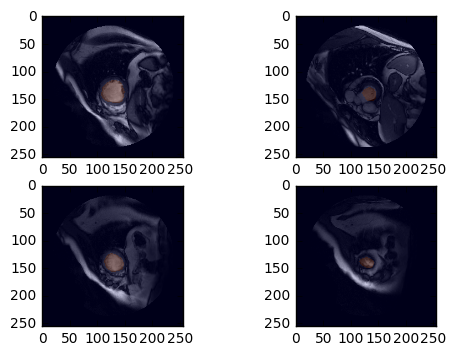

96 (256, 256)
96 (256, 256)


In [16]:
## Part 1

dicom_path = "./final_data/dicoms"
contours_path = "./final_data/contourfiles"
dicom_contour_link = pd.read_csv("./final_data/link.csv")

## Drop any rows or patient records where either contour or dicom images are not available
dicom_contour_link.dropna() 

## n : Number of patients.
## masked_contour : Targets
## dicom_slice : Train Images

n = len(dicom_contour_link['original_id'])
masked_contour = []
dicom_slice = []


## Get the directory path for each patient
for i in range(n):
    curr_dicom_path = dicom_path + '/' + str(dicom_contour_link['patient_id'][i])
    curr_contour_path = contours_path + '/' + str(dicom_contour_link['original_id'][i]+ '/' + 'i-contours')
    
    ## num_contours : number of contours files in a particular directory
    num_contours = len(os.listdir(curr_contour_path))
    
    for j in range(num_contours):
        contour_extract = os.listdir(curr_contour_path)[j]
        contours_coordinates = parse_contour_file(curr_contour_path+'/'+contour_extract)
        ## Multiplying by 1 to convert True/False to 1/0
        masked_contour_a = poly_to_mask(contours_coordinates,256,256)*1 
        masked_contour.append(masked_contour_a)
        
        ## Extract the image number from the string (Need to automate it to make it much more general)
        dicom_extract = (curr_dicom_path + '/' + str(int(contour_extract[9:12]))+'.dcm') 
        dicom_slice_a = (parse_dicom_file(dicom_extract))
        dicom_slice.append(dicom_slice_a['pixel_data'])

fig = plt.figure()
for num in range(4):
    y = fig.add_subplot(2,2,num+1)
    #print(each_slice['pixel_data'])
    y.imshow(dicom_slice[num],cmap = 'gray')
    y.imshow(masked_contour[num], 'jet', interpolation='none', alpha=0.2)
plt.show()
print(len(dicom_slice), (dicom_slice[0].shape))
print(len(masked_contour),(masked_contour[0].shape))


1. How did you verify that you are parsing the contours directly?
A : I manually checked if the code was working for one mask by plotting it on the image file.

2. Any changes made to the given code 'parsing.py'?
A : No.

In [14]:
## Part 2

X = np.asarray(dicom_slice)
Y = np.asarray(masked_contour)

batch_size = 8
num_samples = X.shape[0]


nb_epochs = 5
for i in range(nb_epochs):
    
    ## Train_step : Number of training steps
    ## Shuffle the whole dataset once before creating batches
    shuffle_index = sample(range(num_samples), X.shape[0])
    X_S = X[shuffle_index]
    Y_S = Y[shuffle_index]
    
    ## Sample is used to generate unique since randint may result in repeated integers
    nb_batches = int(np.ceil(num_samples/batch_size))
    for j in range(nb_batches):
        x_index = sample(range(batch_size*j,batch_size*(j+1)), batch_size)
        X_batch = X_S[x_index]
        Y_batch = Y_S[x_index]
    ### Call train model inside the second loop or some packages take care of generating batches e.g keras/tflearn
    #print(X_batch.shape)
    #print(Y_batch.shape)

1. I made a separate one for part 2. Definitely could make it more efficient in resouces and space. By randomizing the patient id and also the contour file that was selected.

2. Same as before : Manually checking the masking. However, we could make it more robust by keeping a count of (sum of all pixels - sum of all pixels in contour) per image pair.

3. Make it a function call rather than stand alone part of the code. Would make the code much more easier to read. Especially the second part of the loop.